# Introduction
In `2. Toxic Comment Classification - Baseline` I recast the challenge in [Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) to a binary classification problem between clean and toxic. I achieved a baseline Average Precision Score, APS, of 0.874 using logistic regression and a bag of words model.

In this notebook I will tackle the problem using pre-trained word embeddings (GloVe) and a convolutional neural network.

I expect that many words in the comments will be out of vocabulary for the GloVe embeddings, which I will need to explore. 

# Read Data

In [1]:
import pandas as pd

data = pd.read_csv('data/train.csv')
# Limit to comments that are either toxic or clean
data = data.loc[data['toxic'] | ~data.iloc[:,2:].any(1)]
data = data.loc[:,['comment_text', 'toxic']]

## Tokenize Data

In [2]:
from nltk import word_tokenize

In [3]:
data.loc[:,'comment_text'] = data.loc[:,'comment_text'].apply(word_tokenize)

In [4]:
data.loc[:,'comment_text'] = data.loc[:,'comment_text'].apply(lambda s: [tok.lower() for tok in s])

In [5]:
from functools import reduce

n_sentences = len(data)
n_tokens = reduce(lambda x, y: x + len(y), data.loc[:,'comment_text'].values, 0)

print("The data set contains {} sentences and {} tokens".format(n_sentences, n_tokens))

The data set contains 158640 sentences and 12732741 tokens


## Construct token correction mapping
In an attempt to allign as many tokens as possible in the raw data to tokens in GloVe I will construct a dictionary with conversions, which I will add on to iteratively.

Start of with a mapping where the target of all initial tokens is unkowns: `None`.

In [6]:
%%time
token_mapping = {}
token_counts = {}
for sentence in data.loc[:,'comment_text']:
    for tok in sentence:
        if tok not in token_mapping:
            token_mapping[tok] = None
            token_counts[tok] = 1
        else:
            token_counts[tok] += 1

Wall time: 7.02 s


In [7]:
print("There are %d unique tokens in the unprocessed data" % len(token_mapping))

There are 258274 unique tokens in the unprocessed data


# Glove Embeddings

I will opt to use the 100 dimensional Glove 6B data. My vocabulary will be exactly the words inside the pretrained model.

In [8]:
import os.path

In [9]:
import numpy as np

In [10]:
glove_path = 'C:/Users/Gustav/Data Science/glove.6B/glove.6B.100d.txt'
embeddings = {}
token_index = {}
index_token = {}
embedding_dims = 100
with open(glove_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        tok, *vec = line.split()
        embeddings[tok] = np.array(vec, dtype='float32')
        # Reserve index 0 for padding
        token_index[tok] = i + 1
        index_token[i+1] = tok

# Allign Comments to GloVe

In [11]:
import re
import tqdm
import string

def allign_to_vocab(vocab, mapping):
    
    # Allign directly
    mapping = allign_with_func(mapping, vocab, direct_allignment)
    print("%d OOV tokens before pre processing" % len(find_oov(mapping)))
    
    # Allign by replacing URL's with 'url'
    mapping = allign_with_func(mapping, vocab, convert_url)
    print("%d OOV tokens after replacing urls with 'url'" % len(find_oov(mapping)))
    
    # Allign by converting to word within 1 Levensthein Damerau distance
    mapping = allign_with_func(mapping, vocab, find_one_neighbour)
    print("%d OOV tokens after spelling correction" % len(find_oov(mapping)))
    
    return mapping

def find_oov(mapping):
    oov = []
    for tok, target in mapping.items():
        if not target:
            oov.append(tok)
    return oov

def find_targets(oov, allignment_func, vocab):
    targets = []
    print("Applying function to oov tokens:")
    for tok in tqdm.tqdm(oov):
        targets.append(allignment_func(tok, vocab))
    return targets

def allign_with_func(mapping, vocab, func):
    oov = find_oov(mapping)
    oov_targets = find_targets(oov, func, vocab)
    for tok, target in zip(oov, oov_targets):
            mapping[tok] = target
    return mapping

def direct_allignment(token, vocab):
    if token in vocab:
        return token
    else:
        return None
    
     
def convert_url(token, vocab):
    # Match words starting with www., http:// or https://
    if re.match(r'^(?:https{0,1}\:\/\/.*|www\.*)', token):
        return "url"
    else:
        return None

# Checks for vocabulary words within 1 Damerau Levenstein distance and returns the first match
# Logic inspired by http://norvig.com/spell-correct.html
def find_one_neighbour(word, vocab):
    
    if len(word) <= 2:
        return None
    
    ascii_vocab = string.ascii_lowercase
    
    # Tuples with all possible splits of word
    splits = [(word[:i], word[i:]) for i in range(len(word))]
    
    # All words generated by deleting one character
    for L, R in splits:
        candidate = L + R[1:] if R else None
        if candidate in vocab:
            return candidate
    # All words generated by swapping two characters in word
    for L, R in splits:    
        candidate = L + R[1] + R[0] + R[2:] if len(R) > 1 else None
        if candidate in vocab:
            return candidate
    # All words generated by inserting a character in word
    for L, R in splits:
        for c in ascii_vocab:    
            candidate = L + c + R 
            if candidate in vocab:
                return candidate
    # All words generated by replacing a character in word
    for L, R, in splits:
        for c in ascii_vocab:    
            candidate = L + c +R[1:] if R else None
            if candidate in vocab:
                return candidate
        
    return None
    

In [12]:
%%time
token_mapping = allign_to_vocab(embeddings, token_mapping)

Applying function to oov tokens:


100%|██████████████████████████████████████████████████████████████████████| 258274/258274 [00:00<00:00, 686961.36it/s]


156360 OOV tokens before pre processing
Applying function to oov tokens:


100%|██████████████████████████████████████████████████████████████████████| 156360/156360 [00:00<00:00, 330096.75it/s]


155920 OOV tokens after replacing urls with 'url'
Applying function to oov tokens:


100%|████████████████████████████████████████████████████████████████████████| 155920/155920 [01:01<00:00, 2552.05it/s]


99793 OOV tokens after spelling correction
Wall time: 1min 2s


How frequent are OOV tokens?

In [13]:
oov = find_oov(token_mapping)
oov_count = 0
for tok in oov:
    oov_count += token_counts[tok]

print("%d tokens in the data, thats %.3f%% of all tokens" % (oov_count, 100 * oov_count / n_tokens))

205355 tokens in the data, thats 1.613% of all tokens


Cool, so even though we still have 200K unkown tokens in the data, they are not that common.

Now let's check what spelling mistakes we fixed.

In [14]:
fixed_spelling = {}
for tok, target in token_mapping.items():
    if tok != target and tok != 'url' and target:
        fixed_spelling[tok] = target
        

Let's just peek at 100 fixes.

In [15]:
for i, (tok, target) in enumerate(fixed_spelling.items()):
    if i == 100:
        break
    print("%s -> %s" % (tok, target))

vandalisms -> vandalism
21:51 -> 1:51
'nonsense -> nonsense
'animal -> animal
'image -> image
contribs -> contries
it.. -> i.t.
-contribution -> contribution
aircracft -> aircraft
caculator -> calculator
comming -> coming
georgiev- -> georgiev
acctually -> actually
delting -> elting
'the -> the
deepu -> depu
falsities -> falsifies
re-considering -> reconsidering
re-visit -> revisit
reconsidered. -> reconsidered
'fight -> fight
-much -> much
el_c -> elc
t/c -> tc
basis. -> basis
generarizations -> generalizations
—the -> the
rurika -> rurik
eced -> ced
shwain -> swain
.with -> with
ammended -> amended
scholary -> scholar
recongise -> recognise
absoutely -> absolutely
hastol -> haston
do. -> o.
possibillity -> possibility
concepts. -> concepts
altitu -> altit
=tony -> tony
citiations -> citations
triva -> riva
wiaga -> waga
ga-class -> a-class
'talk -> talk
|talk -> talk
neiln -> nein
–talk -> talk
thatso -> thats
right. -> right
mabuska -> maruska
qoute -> quote
.thanks -> thanks
well. 

A lot of these fixes just remove some uncessesary character in the original token. This is a good thing.
However, some of these fixes are not propper spelling fixes, like `"5-5-5" -> "5-55"`. I will accept them anyway though, as I think they will make little difference.

## Apply the data corrections

In [16]:
def correct_tok(tok, mapping):
    target = mapping[tok]
    
    return target if target else 'unk'

In [17]:
data.loc[:,'comment_text'] = data.loc[:,'comment_text'].apply(lambda s: [correct_tok(tok, token_mapping) for tok in s])

Check sequence lengths

In [18]:
data.loc[:,'seq_len'] = data.loc[:,'comment_text'].apply(len)

data.loc[:,'seq_len'].describe()

count    158640.000000
mean         80.261857
std         120.712026
min           1.000000
25%          20.000000
50%          43.000000
75%          89.000000
max        4948.000000
Name: seq_len, dtype: float64

Some sequences are very long...

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [20]:
binned_seq_lens = np.bincount(data.loc[:,'seq_len'])
n_bins = len(binned_seq_lens)
binned_seq_lens_acu = np.cumsum(binned_seq_lens)

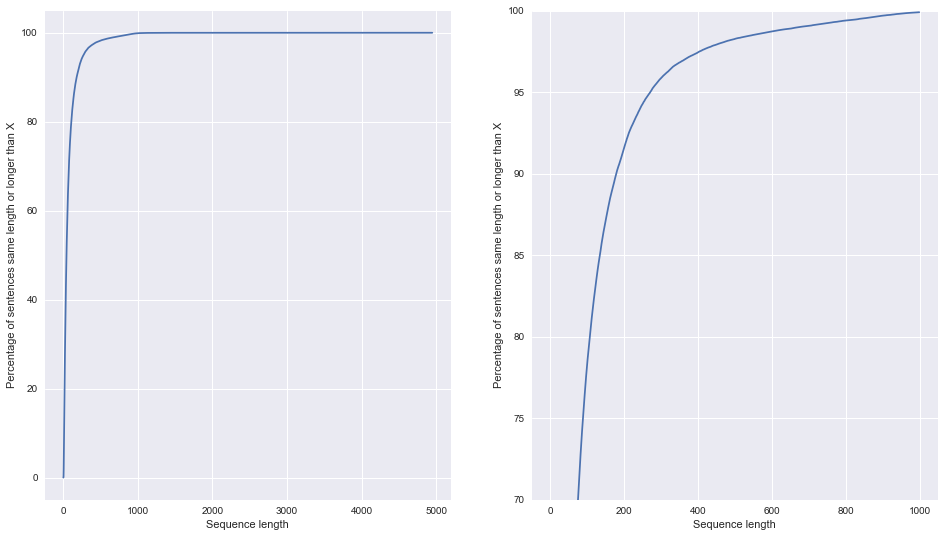

In [21]:
f, ax = plt.subplots(1, 2, figsize=(16,9))
ax[0].plot(np.arange(n_bins), 100 * binned_seq_lens_acu/len(data))
ax[1].plot(np.arange(1000), 100 * binned_seq_lens_acu[:1000]/len(data))
ax[1].set_ylim([70,100])
ax[0].set_xlabel('Sequence length')
ax[0].set_ylabel('Percentage of sentences same length or longer than X')
ax[1].set_xlabel('Sequence length')
ax[1].set_ylabel('Percentage of sentences same length or longer than X')

In [22]:
binned_seq_lens_acu[100]/len(data)

0.7835665658093798

I should probably clip the sequences to a fixed max length. Maybe I can try setting max length to 100 to start with? This will be easier for my mode lto process, but might have negative impacts on results as it will clip the end of almost 22% of all sentences.

## Convert embeddings to tensor

In [23]:
import torch

In [24]:
embedding_weights = torch.zeros(len(embeddings) + 1, embedding_dims)
for tok, i in token_index.items():
    embedding_weights[i] = torch.from_numpy(embeddings[tok])

## Convert data to tensors

In [25]:
y = data.loc[:,'toxic'].values

In [26]:
X = [torch.from_numpy(np.asarray([token_index[tok] for tok in sentence])).long() for sentence in data.loc[:,'comment_text']]

## Divide data into Train, Validation and Test set

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=.15, random_state=0, stratify=y_train)

In [28]:
y_train = torch.from_numpy(y_train)
y_dev = torch.from_numpy(y_dev)
y_test = torch.from_numpy(y_test)

## Pad the Data

In [123]:
class PaddedAndClipGenerator():
    def __init__(self, x_set, y_set = None, batch_size = 126, max_len = 100, shuffle_batches=False):
        
        self.max_len = max_len
        self.reshuffle = shuffle_batches
        
        if y_set is not None:
            self.has_label = True
        else:
            self.has_label = False
            
        self.batch_size = batch_size
        if self.has_label:
            self.x, self.y, self.sequence_lengths = [], [], []
        else:
            self.x, self.sequence_lengths = [], []
        # Pad Data so all batches have sequences of equal length
        for idx in range(int(np.ceil(len(x_set) / float(self.batch_size)))):
            batch_x = x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            
            # The input is sorted so the first sequence is the longest
            batch_seq_len = min([len(batch_x[0]), self.max_len])
            batch_x_pad = torch.zeros(len(batch_x), batch_seq_len, dtype=torch.long)
            batch_sequence_lengths = torch.Tensor(list(map(len, batch_x))).int()
            
            for i, (seq, seq_len) in enumerate(zip(batch_x, batch_sequence_lengths)):
                seq_len = min([batch_seq_len, seq_len])
                batch_x_pad[i,:seq_len] = seq[:seq_len] 
            
            self.x.append(batch_x_pad)
            
            if self.has_label:
                batch_y = y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
                self.y.append(batch_y)
        self.shuffle_batches()
            
            
    def shuffle_batches(self):
        idx = np.random.permutation(len(self.x))
        self.x = [self.x[i] for i in idx]
        self.y = [self.y[i] for i in idx]
    
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if self.has_label:
            return self.x[idx], self.y[idx]
        else:
            return self.x[idx]

In [58]:
def sort_sequences(X, y):
    seq_lens = [len(x) for x in X]
    idx = np.argsort(seq_lens)[::-1]
    X = [X[i] for i in idx]
    y = torch.Tensor([y[i] for i in idx])
    return X, y

In [61]:
X_train, y_train = sort_sequences(X_train, y_train)
X_dev, y_dev = sort_sequences(X_dev, y_dev)
X_test, y_test = sort_sequences(X_test, y_test)

In [124]:
train_padded = PaddedAndClipGenerator(X_train, y_train, batch_size=126, shuffle_batches = True)
dev_padded = PaddedAndClipGenerator(X_dev, y_dev, batch_size=126, shuffle_batches = True)
test_padded = PaddedAndClipGenerator(X_test,y_test,  batch_size=126, shuffle_batches = True)

# CNN
Let's build the CNN.

In [33]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_weights):
        super(CNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_weights.size(1)
        
        # Pre-trained embeddings, allowed to be refit during training
        self.embedding = nn.Embedding(*embedding_weights.shape, _weight=embedding_weights, padding_idx=0)
        
        # Convolutional Layers (1 Padding to ensure we can process sequences of length 1)
        self.conv1 = nn.Conv1d(self.embedding_size, 100, 3, padding=1)
        
        # Fully Connected
        self.fc = nn.Linear(100, 1)
        
        
    def forward(self, batch):
        
        # BxL
        
        # Embeddings
        embedded = self.embedding(batch).permute([0, 2, 1]) # BxCxL
        
        # Convolutions
        x = self.conv1(embedded) #BxCxL
        x = F.relu(x) #BxCxL
        x = F.max_pool1d(x, kernel_size=x.size(2)).reshape(batch.size(0), -1) #BxC
        
        # Fully connected
        x = self.fc(x) #B
        
        # Fully Connected
        #x = torch.sigmoid(x) #B
        return x

In [84]:
import torch.optim as optim

In [85]:
toxic_weight = len(y_train) / y_train.sum()

In [128]:
cnn1 = CNNClassifier(embedding_weights.size(0), 100, embedding_weights)

criterion = nn.BCEWithLogitsLoss(pos_weight=toxic_weight)
optimizer = optim.Adam(cnn1.parameters())

In [129]:
from sklearn.metrics import average_precision_score

In [130]:
from tqdm import tqdm_notebook

# Function inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, train_generator, optimizer, criterion, dev_generator=None, epochs = 2):
    
    # Only enter the validation state if there is a validation_loader
    phases = ['train']
    data_dict = {'train' : train_generator} 
    if dev_generator:
        phases.append('val')
        data_dict['val'] = dev_generator
        
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        for phase in phases:
            
            data = data_dict[phase]
            
            # Only update model weights based on the training data
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            comments_processed = 0
            epoch_probas = []
            epoch_labels = []
            
            pbar = tqdm_notebook(data, total = len(data))
            for seq, labels in pbar:

                optimizer.zero_grad()
                
                # Only track history during training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(seq).reshape(-1)
                    loss = criterion(outputs, labels)
                    probas = torch.sigmoid(outputs)
                    predictions = probas > .5
                    
                    # Only perform backpropagation during training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Save statistics
                running_loss += loss.item()
                # Only count correct classifications when the label is not padding
                running_corrects += torch.sum(predictions == labels.data.byte())
                comments_processed += len(seq)
                
                epoch_probas += [prob.item() for prob in probas]
                epoch_labels += list([label.item() for label in labels.byte()])
                
                pbar.set_description("APS: %.3f" % average_precision_score(epoch_labels, epoch_probas))
                
                
            epoch_loss = running_loss / comments_processed
            epoch_acc = running_corrects.item() / comments_processed
            epoch_average_precision_score = average_precision_score(epoch_labels, epoch_probas)
            
            if data.reshuffle:
                # Shuffle the batch order so it's not the same next epoch
                data.shuffle_batches()
            
            print('{} Loss: {:.4f} Acc: {:.4f}, APS: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_average_precision_score))
                
            

In [131]:
train_model(cnn1, train_padded, optimizer, criterion, dev_generator=dev_padded)

Epoch 1/2
----------


A Jupyter Widget

train Loss: 0.0023 Acc: 0.9434, APS: 0.9122


A Jupyter Widget

val Loss: 0.0036 Acc: 0.9368, APS: 0.8745
Epoch 2/2
----------


A Jupyter Widget

train Loss: 0.0012 Acc: 0.9676, APS: 0.9606


A Jupyter Widget

val Loss: 0.0041 Acc: 0.9286, APS: 0.8641


In [132]:
train_model(cnn1, train_padded, optimizer, criterion, dev_generator=dev_padded)

Epoch 1/2
----------


A Jupyter Widget

train Loss: 0.0008 Acc: 0.9794, APS: 0.9781


A Jupyter Widget

val Loss: 0.0075 Acc: 0.9528, APS: 0.8494
Epoch 2/2
----------


A Jupyter Widget

train Loss: 0.0005 Acc: 0.9876, APS: 0.9880


A Jupyter Widget

val Loss: 0.0069 Acc: 0.9426, APS: 0.8491


In [134]:
torch.save({'state' : cnn1.state_dict()}, 'pytorch_models/cnn1.pt')

After one epoch the CNN classifier ties my baseline logistic regression model in terms of APS on the validation data. 
Training for two epochs does not improve the vaidation performance though, indicating that the model quickly starts overfitting the training data.

With this model I have done no hyperparameter tuning such as choosing the number of convolutional filters, the kernel size of the convolution and also only use one convolution size. 

I'll need too read up more on what kind of designs to try. Also, I'd like to check the impact of clipping. Am I performing worse on the clipped comments? In that case, should the clipping threshold be increased?